<a href="https://colab.research.google.com/github/bksat90/LLM/blob/main/LLM_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
!pip install transformers
!pip install datasets

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import seaborn as sns
import os


from sklearn.metrics import confusion_matrix, roc_curve
from datasets import load_dataset
from transformers import BertTokenizerFast, TFBertForSequenceClassification, create_optimizer

In [106]:
BATCH_SIZE = 8

In [107]:
# load data
dset = load_dataset("imdb")

In [108]:
print(dset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [109]:
# print the sample data
dset.set_format(type="pandas")
df = dset["train"][:]
df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [110]:
categories = df.label.value_counts()

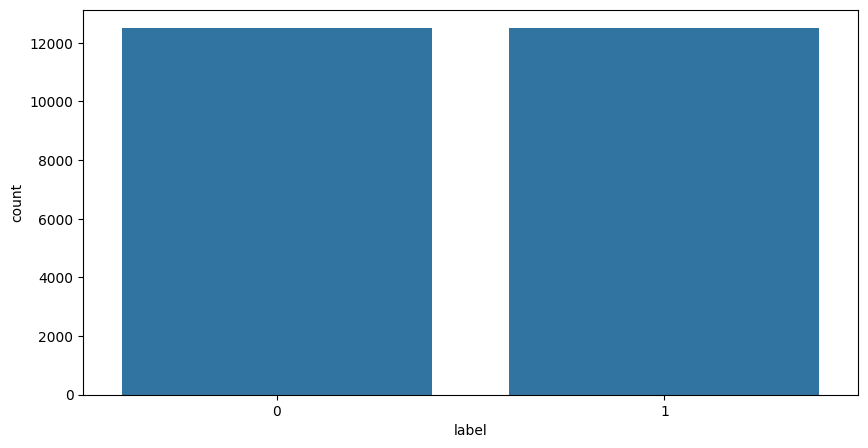

In [111]:
# histogram for the train data
plt.figure(figsize=(10,5))
sns.barplot(categories)
plt.show()

In [112]:
# loading model for tokenizer
model_name="bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [113]:
data = load_dataset("imdb")

In [114]:
# processing the words into tokens
def preprocessing(examples):
  return tokenizer(examples["text"],padding=True,truncation=True,)

In [115]:
# dataset mapping for preprocessing
tokenized_dset = data.map(preprocessing, batched=True)
tokenized_dset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [116]:
# train dataset
train_dataset = tokenized_dset["train"].shuffle(1000).select(range(5000)).to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

In [117]:
# validation dataset
val_dataset = tokenized_dset["test"].shuffle(1000).select(range(5000)).to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

In [118]:
# change the data order
def change_datatype(data):
  return {'input_ids':data['input_ids'],
          'token_type_ids':data['token_type_ids'],
          'attention_mask':data['attention_mask'],},data['label']

In [119]:
# include cache and prefetch elements
train_ds= (
    train_dataset
    .map(change_datatype)
    .prefetch(tf.data.AUTOTUNE)
    .cache())

val_ds = (
    val_dataset
    .map(change_datatype)
    .prefetch(tf.data.AUTOTUNE)
    .cache())

In [120]:
# load the model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=1)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_151 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [121]:
bsize = 8
epochs = 3
epoch_in_batch = len(tokenized_dset["train"].select(range(5000))) // bsize
total_st = int(epoch_in_batch * epochs)

In [122]:
total_st

1875

In [123]:
optimizer, schedule = create_optimizer(init_lr=2e-5,
                                       num_warmup_steps=0,
                                       num_train_steps=total_st)

In [124]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)

In [125]:
history=model.fit(
    train_ds.take(1000),
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/3
625/625 [==============================] - 866s 1s/step - loss: 0.5113 - accuracy: 0.7872 - val_loss: 0.5138 - val_accuracy: 0.8870
Epoch 2/3
625/625 [==============================] - 810s 1s/step - loss: 0.3618 - accuracy: 0.9074 - val_loss: 0.2644 - val_accuracy: 0.9080
Epoch 3/3
625/625 [==============================] - 801s 1s/step - loss: 0.2742 - accuracy: 0.9502 - val_loss: 0.6111 - val_accuracy: 0.9088


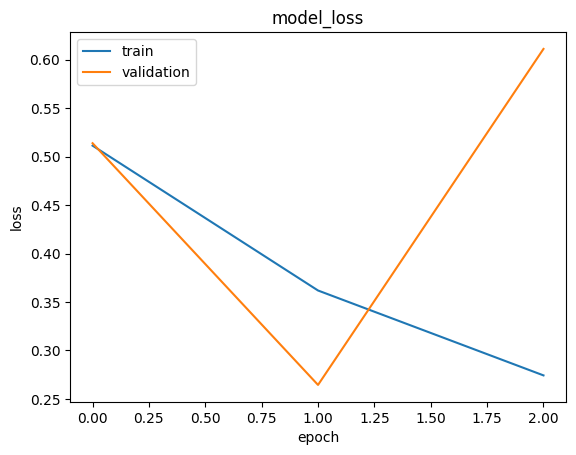

In [126]:
# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

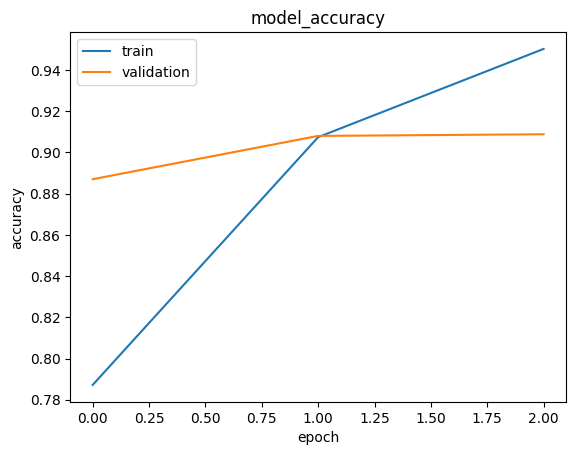

In [127]:
# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [128]:
# reference from https://www.rottentomatoes.com/
# first review is from https://www.rottentomatoes.com/m/indiana_jones_and_the_kingdom_of_the_crystal_skull
# second review is from https://www.rottentomatoes.com/m/ballistic_ecks_vs_sever

inputs = tokenizer(["There are so many levels of nostalgia piled onto Indiana Jones and the Kingdom of the Crystal Skull that it’s hard to unearth a nugget of new inspiration; but the golden oldies that are doled out should dazzle those who cheer for the familiar.",
                    "For many viewers, the big question may be not whether Ecks and Sever will get together, or why they are fighting in the first place, but why am I sitting here, anyway?"],
                   padding=True,return_tensors="tf")

logits = model(**inputs).logits
print(logits)

# obtain probability
pr = tf.nn.softmax(logits, axis=-1)
print(pr)

tf.Tensor(
[[0.8819381 ]
 [0.25796574]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
